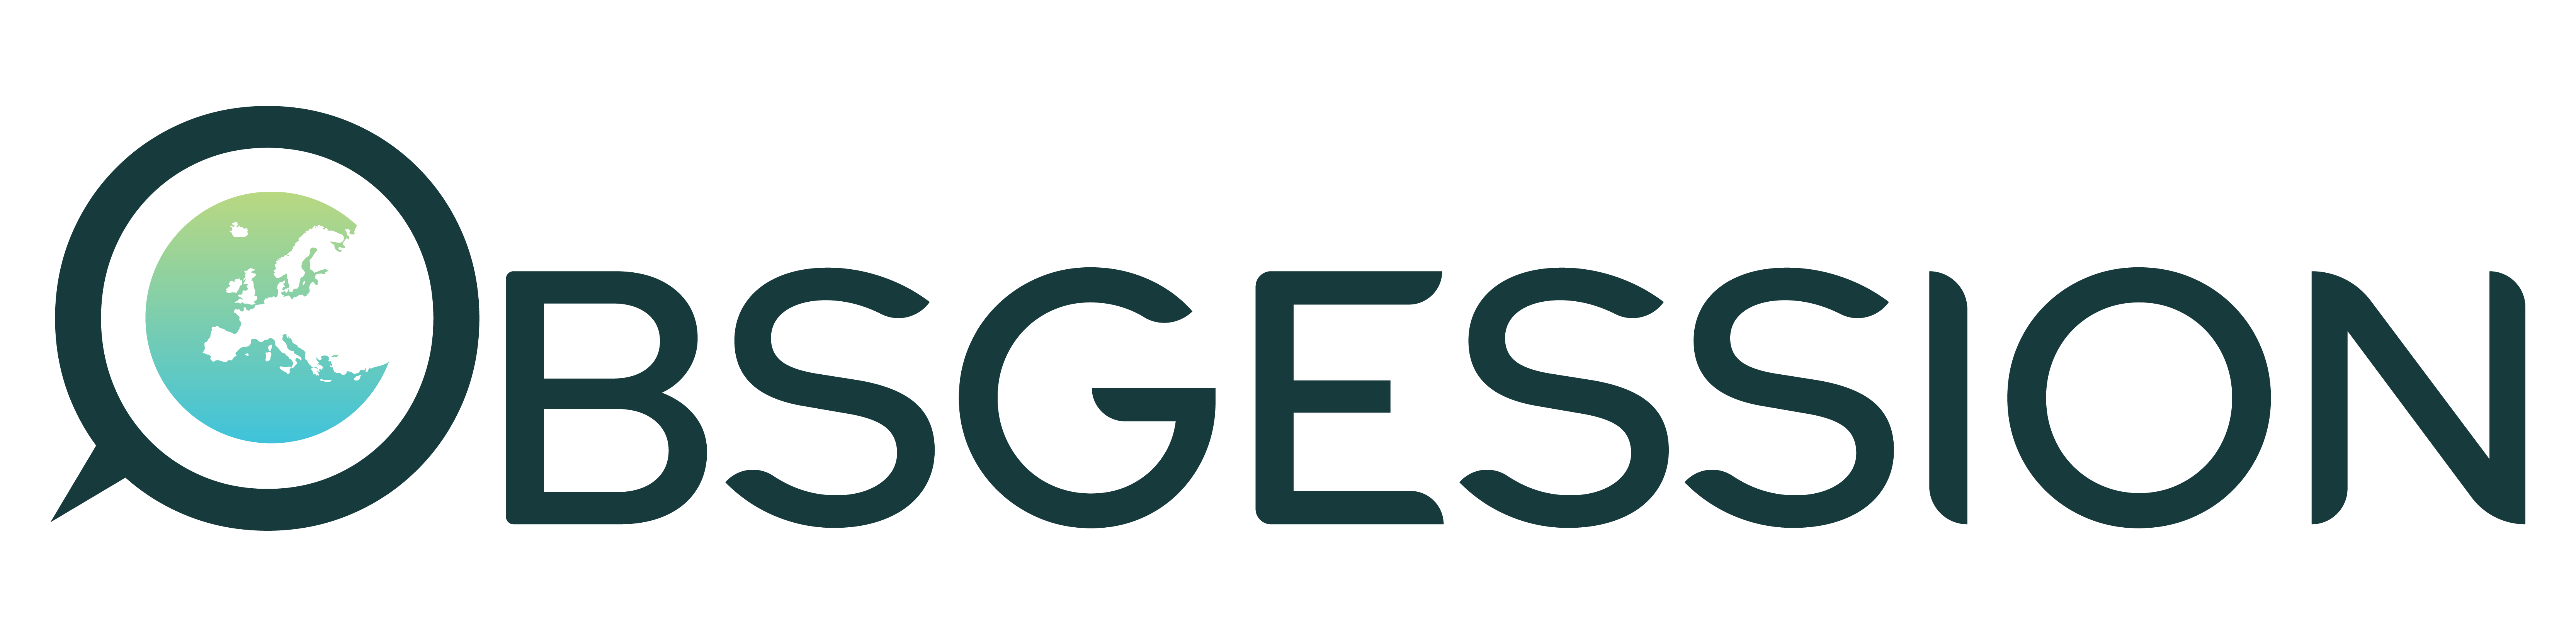

# OBSGESSION internal workshop on EBV-enabling data & data infrastructure
### data processing with openEO - short introduction to use the VITO eo_processing package and the openEO processing platform to generate Sentinel time series and products data cubes
presented by: Dr. Marcel Buchhorn (VITO)
<br>

To run this Jupyter notebook you need the following:
- an CDSE account for data processing in [openEO](https://dataspace.copernicus.eu/). Via green button in the right top corner; following the [documentation to register](https://documentation.dataspace.copernicus.eu/Registration.html).
- an Anaconda Python environment with all needed packages installed
    - follow this manual to set up the Python environment: [python_dev_environment](https://github.com/ESA-WEED-project/.github/tree/main/python_dev_environment)
    - install the eo_processing package in your conda environment:
        - run `conda activate <your_env_name>`
        - run `pip install git+https://github.com/ESA-WEED-project/eo_processing.git@main#egg=eo_processing`

## ADVANCED example - annual features (metrics) generation for ML tasks like habitat mapping in a pipeline
Copyrights, license and restrictions
All code snippets, visualizations or/and workflow ideas are property of VITO. Showed public and private repositories are owned by VITO.
(Re)sharing is only allowed with proper citation of the owners. Publications (peer-review, reports, ...) based partly and/or fully on VITO's hierarchical habitat mapping framework or on one of the provided GitHub repositories must be prior aligned with Dr. Marcel Buchhorn. Code usage is allowed with proper citation, see author list in repository.
base repository: https://github.com/ESA-WEED-project/eo_processing

#### import the needed Python packages

In [1]:
# standard
import os
import geopandas as gpd
import pandas as pd
from typing import Optional
import traceback
import openeo
from openeo.extra.job_management import CsvJobDatabase

# WEED project developments
from eo_processing.config import get_job_options, get_collection_options, get_standard_processing_options
from eo_processing.utils.helper import init_connection, location_visu, string_to_dict
from eo_processing.utils.jobmanager import WeedJobManager
from eo_processing.openeo.processing import generate_master_feature_cube
from eo_processing.utils.geoprocessing import AOI_tiler, bbox_area, geoJson_2_BBOX
from eo_processing.utils.jobmanager import get_AOI_interactive

#### declaration area

Here we set all the needed parameters for the run.

In [3]:
file_name_base = 'feature-datacubes'
version_string = 'v1'
processing_year = 2024

# root output folder
root_base = os.path.normpath(r'C:\Users\BUCHHORM\Downloads') # <--- that has to be the download folder of your browser
out_root = os.path.join(root_base, f'features-cubes_{processing_year}')
os.makedirs(out_root, exist_ok=True)

# backend
backend = 'cdse'  # also possible: cdse-stagging

#### specify space context for the openEO run

The space context is set by intersecting the test sites (AOIs) with the openEO EU 20x20km tiling grid. We are using for this the new AOI_tiler. We use the keyword for the internal 20x20 km LAEA tiling grid for the EU.

In [5]:
get_AOI_interactive(map_center=(52.2, 6.9), zoom=11)

Please draw the AOI and press the EXPORT button.


In [19]:
AOI_bbox = geoJson_2_BBOX(os.path.join(root_base, 'polygon.geojson'), delete_file=True, size_check=600)
print(f"The bounding box is: {AOI_bbox} with an area of {bbox_area(AOI_bbox, only_number=True)} km2")

The bounding box is: {'west': 7.09794, 'south': 52.151081, 'east': 7.121973, 'north': 52.163719, 'crs': 'EPSG:4326'} with an area of 2.3128954051382755 km2


In [21]:
# now the magic of tiling the AOI
gdf_aoi = AOI_tiler(AOI_bbox, 'EU')

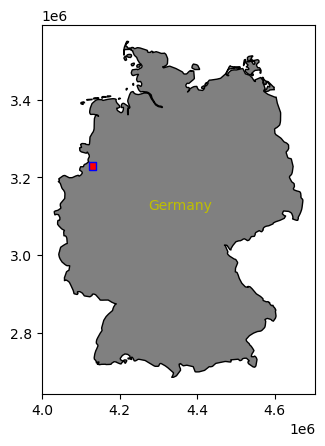

In [23]:
# visualization of the selected- tiles in the tiling grid which needs to be processed to cover the AOI
location_visu(gdf_aoi.drop_duplicates(subset='name', keep='first'), zoom=True, region='EU', label=True)

#### Integration of the MultiBackendJobManager

##### creating the jobs dataframe

The MultiBackendJobManager uses a jobs database to set-up, start and monitor all desired jobs. We are using Pandas/GeoPandas to create a DataFrame storing the job and all parameters which should adapted for each job.

In this example we can directly use the GeoDataFrame of the tiling grid since after the intersection with the AOI is contains only the remaining block extents to process.

Note: for the inference we have to hand over also a lot of additional data to each job like: Model_URLs, list of output band names, ....

In [25]:
def create_job_dataframe(gdf: gpd.GeoDataFrame, year: int, file_name_base: str,
                         target_crs: Optional[int] = None) -> gpd.GeoDataFrame:

    columns = ['name', 'tileID', 'target_epsg', 'bbox', 'file_prefix', 'start_date', 'end_date', 'geometry']
    dtypes = {'name': 'string', 'tileID': 'string', 'target_epsg': 'UInt16',
              'file_prefix': 'string', 'start_date': 'string', 'end_date': 'string',
              'geometry': 'geometry', 'bbox': 'string'}

    job_df = gdf.copy()

    # evaluate if tileID is given by 'name' or 'grid20id'
    if 'grid20id' in job_df.columns:
        tile_col = 'grid20id'  # global grid
    else:
        tile_col = 'name'    # EU grid

    # the time context is given by start and end date
    job_df['start_date'] = f'{year}-01-01'
    job_df['end_date'] = f'{year+1}-01-01'  # the end is always exclusive

    # adding the output file name pre-fix
    job_df['file_prefix'] = job_df.apply(lambda row: f'{file_name_base}_feature-cube_year{year}_{row[tile_col]}', axis=1)

    # set the target epsg
    if target_crs is None:
        job_df['target_epsg'] = job_df.apply(lambda row: int(string_to_dict(row['bbox_dict'])['crs']), axis=1)
    else:
        job_df['target_epsg'] = target_crs

    job_df['bbox'] = job_df['bbox_dict']

    # a fix since the "name" column has to be unique
    job_df['tileID'] = job_df[tile_col].copy()
    job_df['name'] = job_df[tile_col] + f'_{year}'

    return job_df[columns].astype(dtypes)

In [27]:
# create job dataframe
job_df = create_job_dataframe(gdf_aoi, year=processing_year, file_name_base=f'{file_name_base}_{version_string}')
job_df.reset_index(drop=True, inplace=True)

In [29]:
# show the jobs_database before conversion into a JobDatabaseInterface
job_df.head()

,name,tileID,target_epsg,bbox,file_prefix,start_date,end_date,geometry
0,E412N322_2024,E412N322,3035,"{'east': 4140000, 'south': 3220000, 'west': 41...",feature-datacubes_v1_feature-cube_year2024_E41...,2024-01-01,2025-01-01,"MULTIPOLYGON (((7.06889 52.05354, 7.05709 52.2..."


In [31]:
print(f'Number of jobs to run: {job_df.shape[0]}')

Number of jobs to run: 1


##### creating the job start_job function

The next step is to define a start_job function. This function will instruct the MultiBackendJobManager on how to initiate a new job on the selected backend. The start_job functionality should adhere to the following structure start_job(row: pd.Series, connection: openeo.Connection, **kwargs).

Note: the start_job function can only use parameters which are hand over from the job_dataframe! Complex objects like the WEED_storage class can not be used therefore. Geometries can be serialized and stored in the Pandas/GeoPandas row as geojson.FeatureCollection.

In [33]:
def feature_datacube(row: gpd.GeoSeries, connection: openeo.Connection, provider: str , **kwgs) -> openeo.BatchJob:
    """Start a new job using the specified row out of the jobs GeoDataFrame and connection."""

    #### parameter section
    # extract needed parameters from the dataframe row
    tileID = row["tileID"]
    start = row["start_date"]
    end = row["end_date"]
    file_name = row["file_prefix"]
    epsg = int(row["target_epsg"])

    # convert the row name into a openEO bbox dict giving the spatial extent of the job
    processing_extent = string_to_dict(row["bbox"])
    # define job_options, processing_options,  and collection_options
    job_options = get_job_options(provider=provider, task='feature_generation')
    collection_options = get_collection_options(provider=provider)
    processing_options = get_standard_processing_options(provider=provider, task='feature_generation')
    # adapt the epsg to the processing grid
    processing_options.update(target_crs = epsg)

    #### create the feature cube
    # define the S1/S2 processed feature cube (Note: do not set spatial extent since we hand it over in the end)
    data_cube = generate_master_feature_cube(connection,
                                             None,
                                             start,
                                             end,
                                             **collection_options,
                                             **processing_options)

    # filter spatial the whole cube
    data_cube = data_cube.filter_bbox(processing_extent)

    #### create job progress graph
    saved_cube = data_cube.save_result(format="GTiff",
                                        options={
                                            'separate_asset_per_band': False,   # set to False if a datacube
                                            # (Rasterstack with each band other feature) is desired,
                                            # set to True if datacube (one band/feature per GeoTIFF) is desired
                                            # (this facilitates export cause less heavy)
                                            'filename_prefix': file_name
                                        })

    # quick fix for issue with write-out performance - less STAC metadata is produced but for this pipeline no issue.
    job_options.update({"detailed_asset_metadata":False})

    job = saved_cube.create_job(title=file_name,
                                description=f'generation of full feature data cube for tile {tileID}',
                                job_options=job_options)
    return job

##### run the jobs

With our jobs database and job definition set up, we can now run the jobs using the MultiBackendJobManager. This involves defining a path to where we will store the job tracker which contains the job statuses and metadata.

Note: If the specified job tracker path, points to an existing jobs database (either a .csv or .parquet file), that file will be used as the job tracker, and the input jobs database will be disregarded.

In [35]:
# generate a unique name for the job tracker database (here: CSV file)
job_tracker = os.path.normpath(os.path.join(out_root, f'job_tracker_{file_name_base}_{version_string}_feature-cubes-openEO.csv'))
# init of MultiBackendJobManager (A viz switch has been added to enable vizualization of status)
manager = WeedJobManager(root_dir=out_root, poll_sleep=10, viz=True)
# create a connection to backend and add this active backend to the jobmanager
connection = init_connection(backend)
manager.add_backend(backend, connection=connection, parallel_jobs=2)

Authenticated using refresh token.


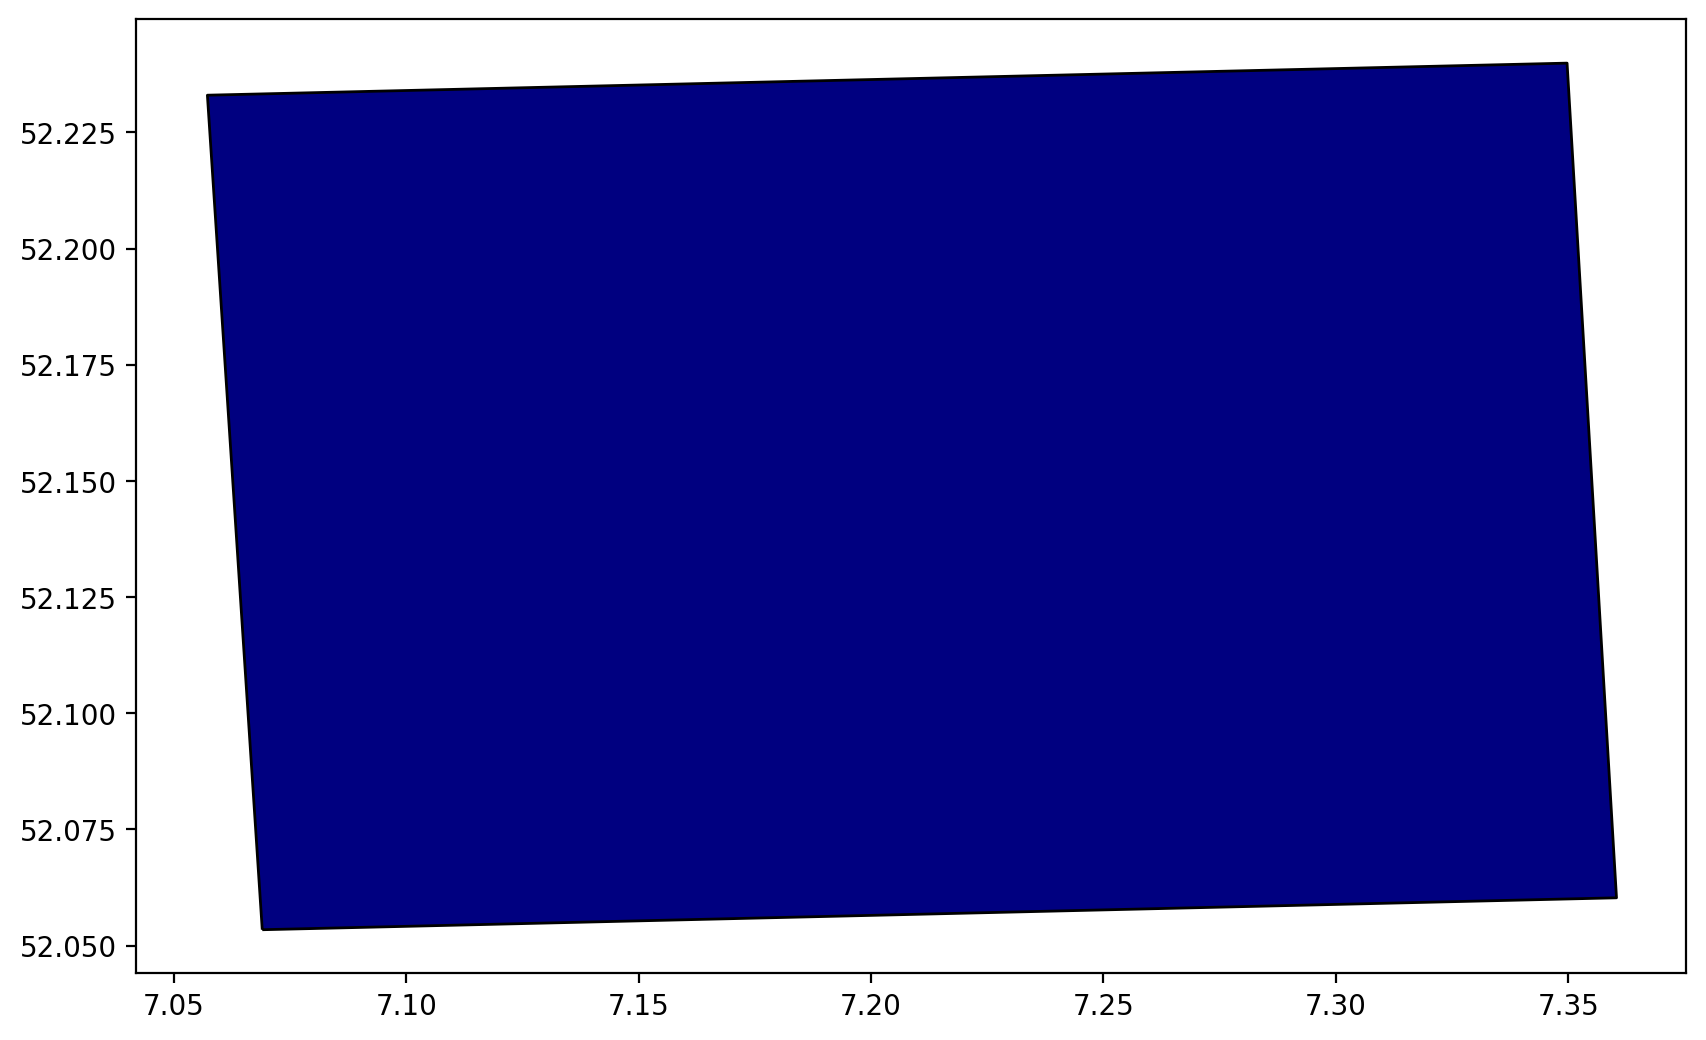

In [ ]:
# due to a bug in the JobManager class we first have to create the CSVJobDatabase by ourself and write it to disk so that we get all custom columns! Note: still loads existing one if no file exists on drive.
job_db = CsvJobDatabase(path=job_tracker)
if job_db.exists():
    print(f"Resuming `run_jobs` from existing {job_db}")
else:
    df = manager._normalize_df(job_df)
    job_db.persist(df)

# now start the jobs with the prepared JobDatabase object
try:
    manager.run_jobs(start_job=feature_datacube, job_db=job_db)
except Exception as e:
    tinfo = traceback.format_exc()
    print(str(e))
    print(tinfo)

##### validate that all needed feature data cubes are generated


In [28]:
# load the job_tracker file into a pandas DataFrame
df_tracker = pd.read_csv(job_tracker)

In [30]:
# Check if all values in column "status" have the value "finished"
all_finished = df_tracker['status'].eq('finished').all()
if all_finished:
    print("All jobs are finished.")
else:
    print("Some jobs are not finished. Reset the non finished status rows to 'not_started' flag and restart the manager.run_jobs() line manually.")

Some jobs are not finished. Reset the non finished status rows to 'not_started' flag and restart the manager.run_jobs() line manually.


In [32]:
# print the costs of the full job
print(f'The feature generation for {df_tracker.shape[0]} 20x20km tiles has cost overall {df_tracker.cost.sum()} credits ({df_tracker.cost.sum() * 0.01} EURO). ')

The feature generation for 1 20x20km tiles has cost overall 0.0 credits (0.0 EURO). 


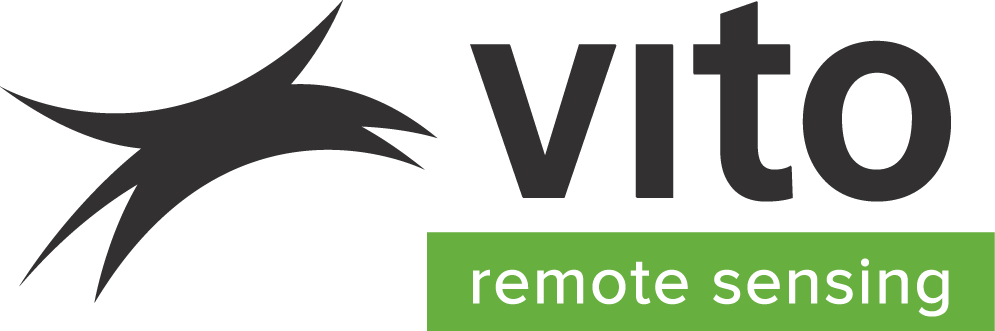